# Задача 1

Поиск характерных признаков режимов.

Цель: подготовить модель для feature importance для произвольной модели кластеризации.

In [73]:
from itertools import accumulate, takewhile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.base import clone
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from utils import DATAFILE_NAMES, TARGET_FEATURE, FIGSIZE, FIGSIZE_NARROW, N_JOBS, RANDOM_SEED, load_all, target_split
from features import *
from models import *
from solutions import *

In [2]:
# здесь подгружаются тестовые датасеты в список dfs
dfs = load_all()

## Подход 1

Нагуглил в инете:

1. Взять размеченные данные (`dfs`);
1. Затем для каждого класса (режима):
    1. Обозначить его как 1, все остальные режимы как 0;
    1. Обучить лес или бустинг, или логистическую регрессию классифицировать эти данные (бинарная классификация);
    1. Оценить важность признаков feature importance для выбранной модели классификации;
    1. Сформировать список наиболее важных признаков для режима.

Условия:

1. Решение должно быть быстрым (катбуст сразу отпадает);
1. Решение должно быть настраиваемым (ни одного параметра не должно быть зашито в решение).

In [3]:
# подготовка данных
def process_df(df, pca=False):
    df = df.dropna()
    # df = df.iloc[::2]
    df = t_discrete(df).drop_duplicates()
    if pca:
        cols = df.columns
        df = t_pca(df, df.shape[1] - 1)
        df.columns = cols
    return target_split(df)

dfs_processed_with_pca = [process_df(df, True) for df in dfs]
dfs_processed_without_pca = [process_df(df, False) for df in dfs]

In [4]:
def look_for_main_features(model, x, y, parallel=True):
    def get_features(model, x, y, mode):
        model = clone(model).fit(x, (y == mode).astype(int))
        return dict(zip(x.columns, model.feature_importances_))
    
    modes = sorted(y.unique())
    if parallel:
        features = Parallel(n_jobs=N_JOBS, prefer='processes')(delayed(get_features)(model, x, y, mode) for mode in tqdm(modes))
    else:
        features = [get_features(model, x, y, mode) for mode in tqdm(modes)]
    return dict(zip(modes, features))

def plot_n_extract_main_features(data, edge=0.7):
    filtered_data = dict()
    feature_count_by_mode = dict()
    mode_count_by_features = dict()
    
    _, ax = plt.subplots(figsize=FIGSIZE)
    for mode, features in data.items():
        features = sorted(features.items(), key=lambda x: x[1])[::-1]
        n = len(list(takewhile(lambda x: x < edge,
                               accumulate(features,
                                          lambda x, y: x + y[1],
                                          initial=0))))
        filtered_data[mode] = dict(features[:n])
        
        best_features = [int(x[0][1:]) for x in features[:n]]
        ax.scatter(best_features, [mode] * n)
        
        feature_count_by_mode[mode] = len(best_features)
        for feature in best_features:
            if feature not in mode_count_by_features:
                mode_count_by_features[feature] = 0
            mode_count_by_features[feature] += 1
    
    ax.set_xlabel('Номер важной фичи')
    ax.set_ylabel('Номер режима')
    plt.show()
    return filtered_data, feature_count_by_mode, dict(sorted(mode_count_by_features.items(), key=lambda x: x[0]))

Получение фичей от RandomForestClassifier

In [5]:
# %%time
# res = []
# model = RandomForestClassifier(random_state=RANDOM_SEED, verbose=False)
# # for num, (x, y) in enumerate([dfs_processed_without_pca[0], dfs_processed_with_pca[0],
# #                               dfs_processed_without_pca[1], dfs_processed_with_pca[1]]):
# for num, (x, y) in enumerate(dfs_processed_without_pca):
#     features = look_for_main_features(model, x=x, y=y)
#     res.append(plot_n_extract_main_features(features, 0.5))

In [6]:
# for features, feature_count_by_mode, mode_count_by_features in res:
#     # print('Количество фич в каждом режиме', *feature_count_by_mode.items(), sep='\n')
#     # print('Количество режимов с этой фичей', *mode_count_by_features.items(), sep='\n')
#     display(pd.Series(mode_count_by_features).value_counts())

Получение фичей от CatBoostClassifier

In [7]:
# %%time
# mode_features_CB = look_for_main_features(model_class=CatBoostClassifier, x=x, y=y)

## Подход 2

Использование Feature selection. 

https://scikit-learn.org/stable/modules/feature_selection.html

Не уверена, что подойдет. Т.к. просто отбрасывает лишние столбцы из датасета. Не знаю пока, как из этой инфы вытащить важные/неважные признаки для каждого отдельного режима.

## Подготовка модели


In [131]:
class FeatureExtractor():
    def __init__(self, model=None,
                 summary_best_feature_importance_edge_values=0.5,
                 feature_intersection_edge=6.5):
        if model is None:
            model = RandomForestClassifier(random_state=RANDOM_SEED, verbose=False)
        self.model = model
        self.edge = summary_best_feature_importance_edge_values
        self.feature_intersection_edge = feature_intersection_edge
    
    def extract_features(self, x, y, parallel=True):
        # define features by feature importance
        def get_features(model, x, y, mode):
            model = clone(model).fit(x, (y == mode).astype(int))
            return dict(zip(x.columns, model.feature_importances_))

        modes = sorted(y.unique())
        if parallel:
            features = Parallel(n_jobs=N_JOBS, prefer='processes')(delayed(get_features)(self.model, x, y, mode) for mode in tqdm(modes))
        else:
            features = [get_features(self.model, x, y, mode) for mode in tqdm(modes)]
        features = dict(zip(modes, features))
        
        def extract_main_features(data, edge=self.edge):
            filtered_data = dict()
            filtered_features = dict()
            for mode, features in data.items():
                features = sorted(features.items(), key=lambda x: x[1])[::-1]
                n = len(list(takewhile(lambda x: x < edge,
                                       accumulate(features,
                                                  lambda x, y: x + y[1],
                                                  initial=0))))
                filtered_data[mode] = dict(features[:n])
                for feature in filtered_data[mode]:
                    if feature not in filtered_features:
                        filtered_features[feature] = 0
                    filtered_features[feature] += 1
            max_feature = ([filtered_features[list(features)[0]] for features in filtered_data.values()])
            filtered_features = {k: v for k, v in filtered_features.items() if v <= 5 or v in max_feature}
            
            for mode in filtered_data:
                filtered_data[mode] = [k for k in filtered_data[mode] if k in filtered_features]
            return filtered_data
        features = extract_main_features(features)
        return features
    
    def glue_modes_by_main_features(self, x, y, features):
        def intersection(d1, d2):
            d0 = set(d1) & set(d2)
            return sum([1 / (d1.index(x) + 1) ** 0.5 for x in d0]) + sum([1 / (d2.index(x) + 1) ** 0.5 for x in d0])
        res = []
        modes = list(features)
        for i1 in range(len(modes) - 1):
            for i2 in range(i1, len(modes)):
                i = intersection(features1[i1], features1[i2])
                if i > self.feature_intersection_edge:
                    res.append([i1, i2])
        mode_groups = [res.pop()]
        while res:
            i1, i2 = res.pop()
            for group in mode_groups:
                if i1 in group or i2 in group:
                    if i1 not in group:
                        group.append(i1)
                    if i2 not in group:
                        group.append(i2)
            else:
                mode_groups.append([i1, i2])
        for i1 in range(len(mode_groups) - 1):
            for i2 in range(i1 + 1, len(mode_groups)):
                if any(np.intersect1d(mode_groups[i1], mode_groups[i2])):
                    mode_groups[i1].extend(mode_groups[i2])
                    mode_groups[i2].clear()
        mode_groups = [list(set(group)) for group in mode_groups if group]
        replacer = dict()
        for group in mode_groups:
            origin, *last = group
            replacer |= {k: origin for k in last}
        return y.replace(replacer)

In [132]:
%%time
x, y = dfs_processed_without_pca[0]
y1 = pd.Series(MyKMeans(len(y.unique()) * 2).fit_predict(x, y), index=y)
model = FeatureExtractor()
features = model.extract_features(x, y1)
ynew = model.glue_modes_by_main_features(x, y1, features)

  0%|          | 0/52 [00:00<?, ?it/s]

Wall time: 1min 59s


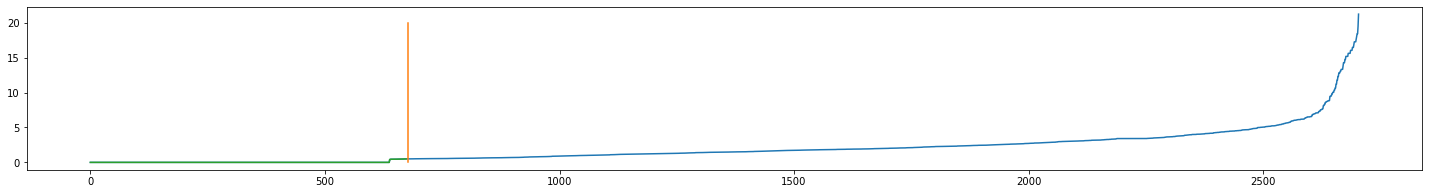

In [89]:
_, ax = plt.subplots(figsize=FIGSIZE_NARROW)
ax.plot(range(len(res)), sorted(res.values))
ax.plot([res.shape[0] / 4] * 2, (0, 20))
r0 = res[res < 0.5]
ax.plot(range(len(r0)), sorted(r0.values))
# r0 = res[res < 1]
# ax.plot(range(len(r0)), sorted(r0.values))